In [1]:
# In this notebook, we will use stats of soccer players on the 2019 FIFA roster to predict their value.

In [2]:
# Load data from csv file.

In [3]:
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': '3SRWJdZAZuTWsEkdcy-zVHrwCLnm4zfxZNtU1JfeoaBe',
    'service_id': 'iam-ServiceId-a7d6e3b0-c39e-4bfa-b544-cd1ca735bd64',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_cef4952e05d8448491fd616525870fe7_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('data.csv', 'default-donotdelete-pr-veoveo1lavfexy'))
df_data_1.show()


+---+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+-------+-----+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------------+
|_c0|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Log

In [4]:
# We first replace spaces with underscores in the column names.

In [5]:
def nospace(name):
    name = name.split(" ")
    name = "_".join(name)
    return name

In [6]:
new_columns = list(map(nospace,df_data_1.columns))
old_columns = df_data_1.columns
for new_c, old_c in zip(new_columns,old_columns):
    df_data_1 = df_data_1.withColumnRenamed(old_c,new_c)

In [7]:
# Export the data frame to a .parquet file on cloud object store. Then read it in as a data frame.

In [8]:
df_data_1 = df_data_1.repartition(1)
df_data_1.write.parquet(cos.url('FIFA.parquet', 'default-donotdelete-pr-veoveo1lavfexy'),mode = 'overwrite')

In [9]:
df_load = spark.read.parquet(cos.url('FIFA.parquet', 'default-donotdelete-pr-veoveo1lavfexy'))

In [10]:
# Let's start by selecting the value column and the stats that we will use to predict it.

In [11]:
# Specific skills of each player are given in columns 54 through 87.

In [12]:
skills = df_load.columns[54:88]
df = df_load.select('Name','Age','Overall','Potential','Value','International_Reputation','Skill_Moves','Position',*skills)

In [13]:
# get_value converts the value column to double format.

In [14]:
def get_value(s):
    
    last = s[-1]
    s = s[1:-1]
    try:
        val = float(s)
    except:
        return 0.0
    
    if last == 'M':
        val = val * 1000000.0
    if last == 'K':
        val = val * 1000.0
    return val

In [15]:
# apply get_value to the value column.

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
get_val_func = udf(get_value,DoubleType())
df = df.withColumn('Value',get_val_func('Value'))

In [17]:
df = df.dropna(subset='Value')
df = df.filter(df.Value != 0)

In [18]:
# There are quite a few positions listed. We reduce these to just five: Goalie, back, midfielder, winger, and striker.
# We will number these 1 to 5, with increasing number moving further up the field.

In [19]:
def Pos(s):
    if s is None:
        return None
    if 'G' in s:
        return 1.0
    if 'B' in s:
        return 2.0
    if 'M' in s:
        return 3.0
    if 'W' in s:
        return 4.0
    if 'S' in s or 'F' in s:
        return 5.0

In [20]:
Pos_func = udf(Pos,DoubleType())
df = df.withColumn('Position',Pos_func('Position'))

In [21]:
df.select('Name','Value','Position').show(5)

+-----------------+-------+--------+
|             Name|  Value|Position|
+-----------------+-------+--------+
|         L. Messi|1.105E8|     5.0|
|Cristiano Ronaldo|  7.7E7|     5.0|
|        Neymar Jr|1.185E8|     4.0|
|           De Gea|  7.2E7|     1.0|
|     K. De Bruyne| 1.02E8|     3.0|
+-----------------+-------+--------+
only showing top 5 rows



In [22]:
# There are many skills listed, but many of the skills are position specific. For example, we don't want to judge a striker based on his goalkeeping skills.
# Therefore, we average the top num_skills skills from each player, reducing many columns to just one. The hyperparameter num_skills can be tuned.

In [23]:
def avg_best(*scores):
    num_skills=5
    scores = list(scores)
    while None in scores:
        scores.remove(None)
    if len(scores)==0:
        return None
    elif len(scores)< num_skills:
        num_skills = len(scores)
    scores = list(map(float,scores))
    scores.sort()
    scores.reverse()
    scores = scores[0:num_skills]
    return sum(scores)/num_skills

In [24]:
avg_best_func = udf(avg_best,DoubleType())
other_cols = df.columns
for col in skills:
    other_cols.remove(col)
df = df.select(*other_cols,avg_best_func(*skills).alias('avg_best'))

In [25]:
df.select('Name','Value','Position','avg_best').show(5)

+-----------------+-------+--------+--------+
|             Name|  Value|Position|avg_best|
+-----------------+-------+--------+--------+
|         L. Messi|1.105E8|     5.0|    95.8|
|Cristiano Ronaldo|  7.7E7|     5.0|    95.2|
|        Neymar Jr|1.185E8|     4.0|    95.0|
|           De Gea|  7.2E7|     1.0|    89.8|
|     K. De Bruyne| 1.02E8|     3.0|    92.2|
+-----------------+-------+--------+--------+
only showing top 5 rows



In [26]:
# We now convert all columns except 'Name' to doubles

In [27]:
cols = df.columns
cols.remove('Name')
cols.remove('Value')


for col in cols:
    df = df.withColumn(col, df[col].cast(DoubleType()))

In [28]:
df.show(5)

+-----------------+----+-------+---------+-------+------------------------+-----------+--------+--------+
|             Name| Age|Overall|Potential|  Value|International_Reputation|Skill_Moves|Position|avg_best|
+-----------------+----+-------+---------+-------+------------------------+-----------+--------+--------+
|         L. Messi|31.0|   94.0|     94.0|1.105E8|                     5.0|        4.0|     5.0|    95.8|
|Cristiano Ronaldo|33.0|   94.0|     94.0|  7.7E7|                     5.0|        5.0|     5.0|    95.2|
|        Neymar Jr|26.0|   92.0|     93.0|1.185E8|                     5.0|        5.0|     4.0|    95.0|
|           De Gea|27.0|   91.0|     93.0|  7.2E7|                     4.0|        1.0|     1.0|    89.8|
|     K. De Bruyne|27.0|   91.0|     92.0| 1.02E8|                     4.0|        4.0|     3.0|    92.2|
+-----------------+----+-------+---------+-------+------------------------+-----------+--------+--------+
only showing top 5 rows



In [29]:
# We replace any missing values with their median accross the dataframe.

In [30]:
med_dict = {}
for col in cols:
    med_dict[col] = df.approxQuantile(col,[0.5],0)[0]
    
med_dict

{'Age': 25.0,
 'International_Reputation': 1.0,
 'Overall': 66.0,
 'Position': 3.0,
 'Potential': 71.0,
 'Skill_Moves': 2.0,
 'avg_best': 73.8}

In [31]:
df = df.fillna(med_dict)

In [32]:
df.show(5)

+-----------------+----+-------+---------+-------+------------------------+-----------+--------+--------+
|             Name| Age|Overall|Potential|  Value|International_Reputation|Skill_Moves|Position|avg_best|
+-----------------+----+-------+---------+-------+------------------------+-----------+--------+--------+
|         L. Messi|31.0|   94.0|     94.0|1.105E8|                     5.0|        4.0|     5.0|    95.8|
|Cristiano Ronaldo|33.0|   94.0|     94.0|  7.7E7|                     5.0|        5.0|     5.0|    95.2|
|        Neymar Jr|26.0|   92.0|     93.0|1.185E8|                     5.0|        5.0|     4.0|    95.0|
|           De Gea|27.0|   91.0|     93.0|  7.2E7|                     4.0|        1.0|     1.0|    89.8|
|     K. De Bruyne|27.0|   91.0|     92.0| 1.02E8|                     4.0|        4.0|     3.0|    92.2|
+-----------------+----+-------+---------+-------+------------------------+-----------+--------+--------+
only showing top 5 rows



In [33]:
# We plot the value and the log of the value against the Overall skill

In [34]:
import math
log_func = udf(math.log,DoubleType())
df_sample = df.sample(False,0.2)
df_sample = df_sample.withColumn('logValue',log_func(df.Value))
ov_list = df_sample.rdd.map(lambda row: row.Overall).collect()
val_list = df_sample.rdd.map(lambda row: row.Value).collect()
log_val_list = df_sample.rdd.map(lambda row: row.logValue).collect()

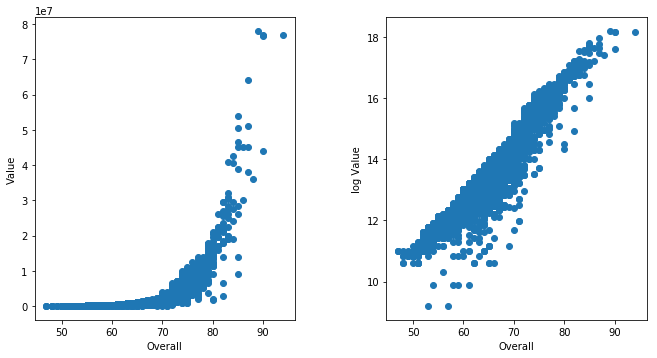

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.xlabel('Overall')
plt.ylabel('Value')
plt.scatter(ov_list,val_list)
plt.subplot(122)
plt.xlabel('Overall')
plt.ylabel('log Value')
plt.scatter(ov_list,log_val_list)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

In [36]:
# We see that the value grows exponentially with the overall skill. The log of the value grows linearly with the overall skill.

In [37]:
# Let's examine the other variables.

In [38]:
Age_list = df_sample.rdd.map(lambda row: row.Age).collect()
Pot_list = df_sample.rdd.map(lambda row: row.Potential).collect()
IR_list = df_sample.rdd.map(lambda row: row.International_Reputation).collect()
SM_list = df_sample.rdd.map(lambda row: row.Skill_Moves).collect()
Pos_list = df_sample.rdd.map(lambda row: row.Position).collect()
ab_list = df_sample.rdd.map(lambda row: row.avg_best).collect()

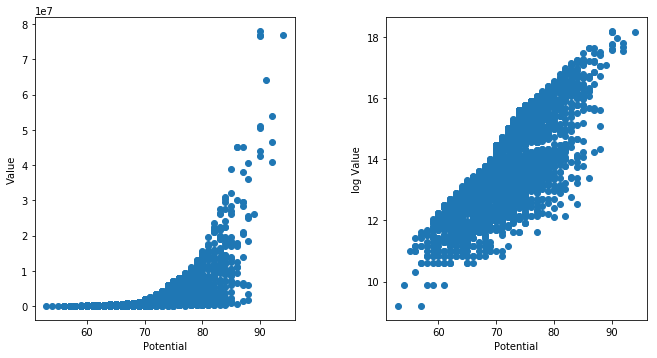

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.xlabel('Potential')
plt.ylabel('Value')
plt.scatter(Pot_list,val_list)
plt.subplot(122)
plt.xlabel('Potential')
plt.ylabel('log Value')
plt.scatter(Pot_list,log_val_list)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

In [40]:
# The relationship between the value and the potential is similar to the relationship between overall skill and potential. However, we see that high potential 
# doesn't translate to high value as readily as high overall skill does.
# We look at the correlation between these two variables.

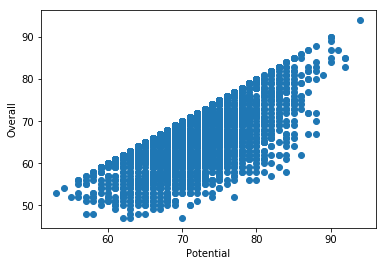

In [41]:
plt.figure(1)
plt.xlabel('Potential')
plt.ylabel('Overall')
plt.scatter(Pot_list,ov_list)
plt.show()

In [42]:
# The two variables are somewhat correlated. In general, players have more potential than Overall Skill. 
#This makes sense since it is not possible to have less potential. 
#We move on to avg_best.

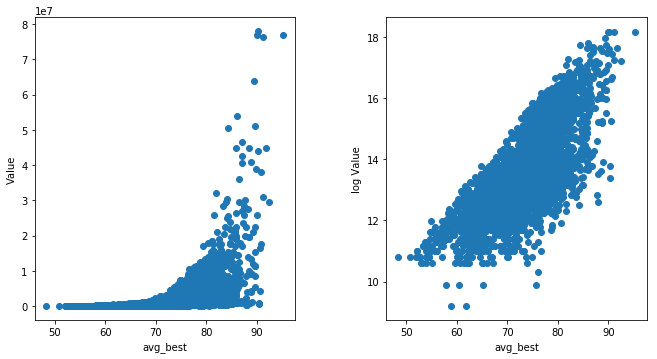

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.xlabel('avg_best')
plt.ylabel('Value')
plt.scatter(ab_list,val_list)
plt.subplot(122)
plt.xlabel('avg_best')
plt.ylabel('log Value')
plt.scatter(ab_list,log_val_list)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

In [44]:
# Just as was the case for the Potential, the relationship looks exponential but high avg_best doesn't necessarily translate to high value in all cases.
#Lets plot the relationship between avg_best and Overall skill

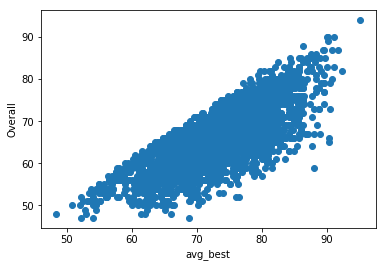

In [45]:
plt.figure(1)
plt.xlabel('avg_best')
plt.ylabel('Overall')
plt.scatter(ab_list,ov_list)
plt.show()

In [46]:
# The two variables are shomewhat correlated. Once again, just as was the case for Potential avg_best is an upper bound for the overall skill.

In [47]:
# We now look at the age.

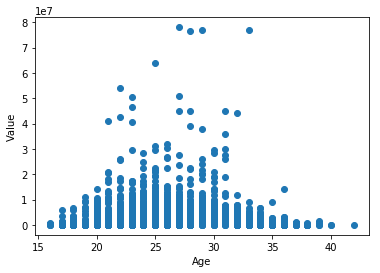

In [48]:
plt.figure(1)
plt.xlabel('Age')
plt.ylabel('Value')
plt.scatter(Age_list,val_list)
plt.show()

In [49]:
# Young players and old players have a lower value, while in the middle of the spectrum age doesn't seem to correlate with value.

In [50]:
# Let's examine the position.

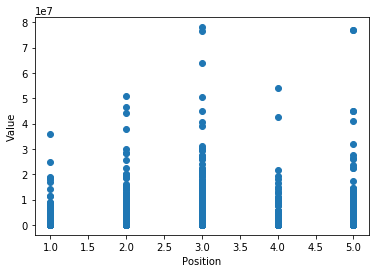

In [51]:
plt.figure(1)
plt.xlabel('Position')
plt.ylabel('Value')
plt.scatter(Pos_list,val_list)
plt.show()

In [52]:
# Midfielders on average have the highest value. Surprisingly, wingers and forwards have low average value, although there are a few outliers with high value.
# These outliers like Ronaldo and Messi are the ones we are used to thinking about, hence the surprise.

In [53]:
# We examine international reputation.

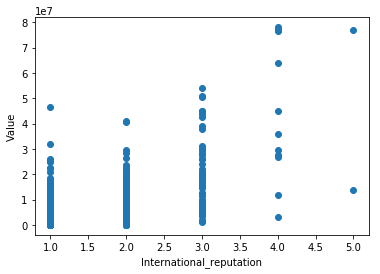

In [54]:
plt.figure(1)
plt.xlabel('International_reputation')
plt.ylabel('Value')
plt.scatter(IR_list,val_list)
plt.show()

In [55]:
#There aren't many players with international reputation above three. In general, higher international reputation corresponds to higher value.

In [56]:
# We look at skill moves next.

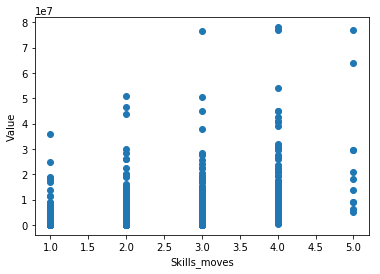

In [57]:
plt.figure(1)
plt.xlabel('Skills_moves')
plt.ylabel('Value')
plt.scatter(SM_list,val_list)
plt.show()

In [58]:
# There is weak correlation between skill_moves and value. Unsurprisingly, higher skill_moves corresponds to higher value.

In [59]:
# We will now perform random forest regression on these features. We first make a features column.

In [60]:
feature_cols = df.columns
for col in ['Name','Value']:
    feature_cols.remove(col)
    
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
VA = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
df = VA.transform(df)

In [61]:
#We treat features with more than five categories as continuous.

In [62]:
from pyspark.ml.feature import VectorIndexer
featureIndexer =  VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(df)
df  = featureIndexer.transform(df)

In [63]:
# Split the data into train_set, val_set, and test_test. 

In [64]:
(train_df,val_df, test_df) = df.randomSplit([0.9,0.05, 0.05])

In [65]:
#Fit Random Forest regression algorithm to train data to predict the value of each player.

In [66]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
rf = RandomForestRegressor( featuresCol = "indexedFeatures",labelCol = 'Value',maxDepth=30, numTrees=40,maxBins=1000)
model = rf.fit(train_df)

In [67]:
predictions = model.transform(train_df)
predictions.select("prediction", "Value", "Name").show(5)

+------------------+---------+-------------+
|        prediction|    Value|         Name|
+------------------+---------+-------------+
| 426970.4861111111| 425000.0|     A. Abang|
|172077.86012296882| 170000.0|A. Abdellaoui|
|3138729.3956043953|3200000.0| A. Abdennour|
| 874694.2155067155| 900000.0|      A. Abdi|
|470201.03594322345| 475000.0|A. Abdu Jaber|
+------------------+---------+-------------+
only showing top 5 rows



In [68]:
evaluator = RegressionEvaluator(labelCol="Value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

320212.51354856626

In [69]:
#Let's evaluate the average percent error on the training set.

In [70]:
from pyspark.sql.functions import *
predictions = predictions.withColumn('per_diff',100*abs(predictions.prediction-predictions.Value)/predictions.Value).orderBy(desc("per_diff")).select("Value","prediction","per_diff","Name")
predictions.select(avg(predictions.per_diff)).show()

+------------------+
|     avg(per_diff)|
+------------------+
|3.1250788566751853|
+------------------+



In [71]:
# We have acheived an average of 3.13% error on the training set.

In [72]:
# Evaluate model on validation set.

In [73]:
predictions = model.transform(val_df)
rmse = evaluator.evaluate(predictions)
rmse

420482.1586616827

In [74]:
predictions = predictions.withColumn('per_diff',100*abs(predictions.prediction-predictions.Value)/predictions.Value).orderBy(desc("per_diff")).select("Value","prediction","per_diff","Name")
predictions.select(avg(predictions.per_diff)).show()

+-----------------+
|    avg(per_diff)|
+-----------------+
|5.557834475308599|
+-----------------+



In [75]:
# We have acheived 5.56% error on the validation set.

In [76]:
# Evaluate model on test set.

In [77]:
predictions = model.transform(test_df)
rmse = evaluator.evaluate(predictions)
rmse

691344.253274338

In [78]:
predictions = predictions.withColumn('per_diff',100*abs(predictions.prediction-predictions.Value)/predictions.Value).orderBy(desc("per_diff")).select("Value","prediction","per_diff","Name")
predictions.show()

+---------+-------------------+------------------+------------+
|    Value|         prediction|          per_diff|        Name|
+---------+-------------------+------------------+------------+
|  30000.0|  161683.3333333333| 438.9444444444444|   M. Taylor|
|  70000.0| 276584.28030303033| 295.1204004329005| J. Carranza|
| 100000.0|  264352.5641025641|164.35256410256412|     Rafinha|
|  20000.0| 47950.694444444445|139.75347222222223|     P. Gori|
|  90000.0| 209938.89260249556|133.26543622499506|    S. Ağçay|
| 120000.0|  265355.9523809523|121.12996031746026|    F. Oreja|
|  20000.0|  43089.58333333333|115.44791666666666|    L. Corti|
|  60000.0| 125729.16666666666| 109.5486111111111| D. Campbell|
| 325000.0|  675469.7646103896|107.83685064935065|K. Beckerman|
|  20000.0|  37456.03739631317| 87.28018698156585|   Y. Uekusa|
|9000000.0|1.456892857142857E7| 61.87698412698412|        Pepe|
|  80000.0|          120843.75|        51.0546875|   A. Reghba|
|  60000.0|  88480.89045266467| 47.46815

In [79]:
predictions.select(avg(predictions.per_diff)).show()

+-----------------+
|    avg(per_diff)|
+-----------------+
|6.906873270302134|
+-----------------+



In [80]:
# We have acheived a 6.91% error on the test set and rmse ~ 700,000 euros. Given the great uncertainty in the value of a soccer player, this data is very noisy.
# Hence, this is a very good result. 

In [81]:
# Finally, we plot the predictions of the test set vs. the actual values.

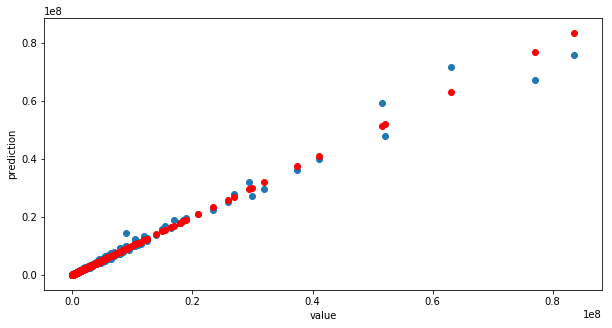

In [82]:
pred_list = predictions.rdd.map(lambda row: row.prediction).collect()
val_list = predictions.rdd.map(lambda row: row.Value).collect()
plt.figure(figsize=(10,5))
plt.xlabel("value")
plt.ylabel("prediction")
plt.scatter(val_list,pred_list)
plt.scatter(val_list,val_list,c="red")
plt.show()

In [83]:
# The predictions are in blue, while the actual values are in red. We see that the algorithm does a pretty good job.